### NYC interactive map with total number of fire incidents and top 4 incident type occuring in NYC neighborhood.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
working_folder = '/content/drive/My Drive/Colab Notebooks/DS1_Interactive_Map/Data/'

Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)

# data files 
# 1- 2010_Census_Populations_by_Zip_Code
# 2- Incidents_Responded_to_by_Fire_Companies
# 3- zip_lat_long

# filename_full =  os.path.join(path,filename)

In [151]:
df_zip = pd.read_csv(f'{working_folder}/zip_lat_long.csv', index_col=0)
tmp_df =  pd.read_csv(f'{working_folder}/Incidents_Responded_to_by_Fire_Companies.csv', 
                      index_col=0, chunksize=1000)#, usecols=['IM_INCIDENT_KEY',
                                                            # 'ZIP_CODE',
                                                            # 'INCIDENT_TYPE_DESC'],
                                                  #dtype={'IM_INCIDENT_KEY': 'Int64',
                                                        # 'ZIP_CODE': 'category',
                                                        # 'INCIDENT_TYPE_DESC': 'category'})

df = pd.concat(tmp_df)

df.ZIP_CODE.replace({'11209-0000': 11209,
                     '11005.0': 11005,
                     '11371.0': 11371,
                     '-31073': 31073,
                     '11451.0': 11451}, inplace=True)

df.ZIP_CODE.dropna(inplace=True)
df.ZIP_CODE = df.ZIP_CODE.astype('int16')
                

df.head()

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,ACTION_TAKEN2_DESC,ACTION_TAKEN3_DESC,PROPERTY_USE_DESC,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,FLOOR,CO_DETECTOR_PRESENT_DESC,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG
IM_INCIDENT_KEY,,,,,,,,,,,,,,,,,,,,,,,
63476768,2928,"746 - Carbon monoxide detector activation, no CO",06/30/2018 11:55:29 PM,07/01/2018 12:00:32 AM,2.0,07/01/2018 12:22:57 AM,11 - First Alarm,1648.0,"42 - HazMat detection, monitoring, sampling, &...",51 - Ventilate,86 - Investigate,429 - Multifamily dwelling,UNDERCLIFF AVE,10453.0,2 - Bronx,1,Yes,NaN,NaN,NaN,NaN,NaN,NaN
63476763,1021,"300 - Rescue, EMS incident, other",06/30/2018 11:54:44 PM,06/30/2018 11:58:59 PM,1.0,07/01/2018 12:09:29 AM,11 - First Alarm,885.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,RUTLAND RD,11203.0,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63476761,2745,"651 - Smoke scare, odor of smoke",06/30/2018 11:54:13 PM,06/30/2018 11:58:29 PM,3.0,07/01/2018 12:07:50 AM,11 - First Alarm,817.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,PROSPECT AVE,10456.0,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63476762,2135,"117 - Commercial Compactor fire, confined to r...",06/30/2018 11:54:08 PM,06/30/2018 11:58:53 PM,5.0,07/01/2018 12:19:16 AM,11 - First Alarm,1508.0,11 - Extinguishment by fire service personnel,51 - Ventilate,NaN,429 - Multifamily dwelling,BROWN PL,10454.0,2 - Bronx,basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63476759,1877,"710 - Malicious, mischievous false call, other",06/30/2018 11:53:33 PM,06/30/2018 11:56:50 PM,1.0,06/30/2018 11:57:11 PM,11 - First Alarm,218.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,DEFAULT RECORD FOR SF,11208.0,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
print(f"In this dataset, we have {len(df.columns)} features including:\n")
list(df.columns)

In this dataset, we have 23 features including:



['FIRE_BOX',
 'INCIDENT_TYPE_DESC',
 'INCIDENT_DATE_TIME',
 'ARRIVAL_DATE_TIME',
 'UNITS_ONSCENE',
 'LAST_UNIT_CLEARED_DATE_TIME',
 'HIGHEST_LEVEL_DESC',
 'TOTAL_INCIDENT_DURATION',
 'ACTION_TAKEN1_DESC',
 'ACTION_TAKEN2_DESC',
 'ACTION_TAKEN3_DESC',
 'PROPERTY_USE_DESC',
 'STREET_HIGHWAY',
 'ZIP_CODE',
 'BOROUGH_DESC',
 'FLOOR',
 'CO_DETECTOR_PRESENT_DESC',
 'FIRE_ORIGIN_BELOW_GRADE_FLAG',
 'STORY_FIRE_ORIGIN_COUNT',
 'FIRE_SPREAD_DESC',
 'DETECTOR_PRESENCE_DESC',
 'AES_PRESENCE_DESC',
 'STANDPIPE_SYS_PRESENT_FLAG']

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2518758 entries, 63476768 to 55672688
Data columns (total 23 columns):
FIRE_BOX                        object
INCIDENT_TYPE_DESC              object
INCIDENT_DATE_TIME              object
ARRIVAL_DATE_TIME               object
UNITS_ONSCENE                   float64
LAST_UNIT_CLEARED_DATE_TIME     object
HIGHEST_LEVEL_DESC              object
TOTAL_INCIDENT_DURATION         float64
ACTION_TAKEN1_DESC              object
ACTION_TAKEN2_DESC              object
ACTION_TAKEN3_DESC              object
PROPERTY_USE_DESC               object
STREET_HIGHWAY                  object
ZIP_CODE                        float64
BOROUGH_DESC                    object
FLOOR                           object
CO_DETECTOR_PRESENT_DESC        object
FIRE_ORIGIN_BELOW_GRADE_FLAG    float64
STORY_FIRE_ORIGIN_COUNT         float64
FIRE_SPREAD_DESC                object
DETECTOR_PRESENCE_DESC          object
AES_PRESENCE_DESC               object
STANDPIPE_SYS_PR

In [154]:
df.isnull().sum()

FIRE_BOX                             10
INCIDENT_TYPE_DESC                    0
INCIDENT_DATE_TIME                    0
ARRIVAL_DATE_TIME                 62312
UNITS_ONSCENE                     62523
LAST_UNIT_CLEARED_DATE_TIME           2
HIGHEST_LEVEL_DESC                  152
TOTAL_INCIDENT_DURATION             149
ACTION_TAKEN1_DESC                    0
ACTION_TAKEN2_DESC              1983186
ACTION_TAKEN3_DESC              2273503
PROPERTY_USE_DESC                     6
STREET_HIGHWAY                    38157
ZIP_CODE                             12
BOROUGH_DESC                          0
FLOOR                           1975680
CO_DETECTOR_PRESENT_DESC        2485756
FIRE_ORIGIN_BELOW_GRADE_FLAG    2516700
STORY_FIRE_ORIGIN_COUNT         2504526
FIRE_SPREAD_DESC                2504527
DETECTOR_PRESENCE_DESC          2504528
AES_PRESENCE_DESC               2504528
STANDPIPE_SYS_PRESENT_FLAG      2504524
dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


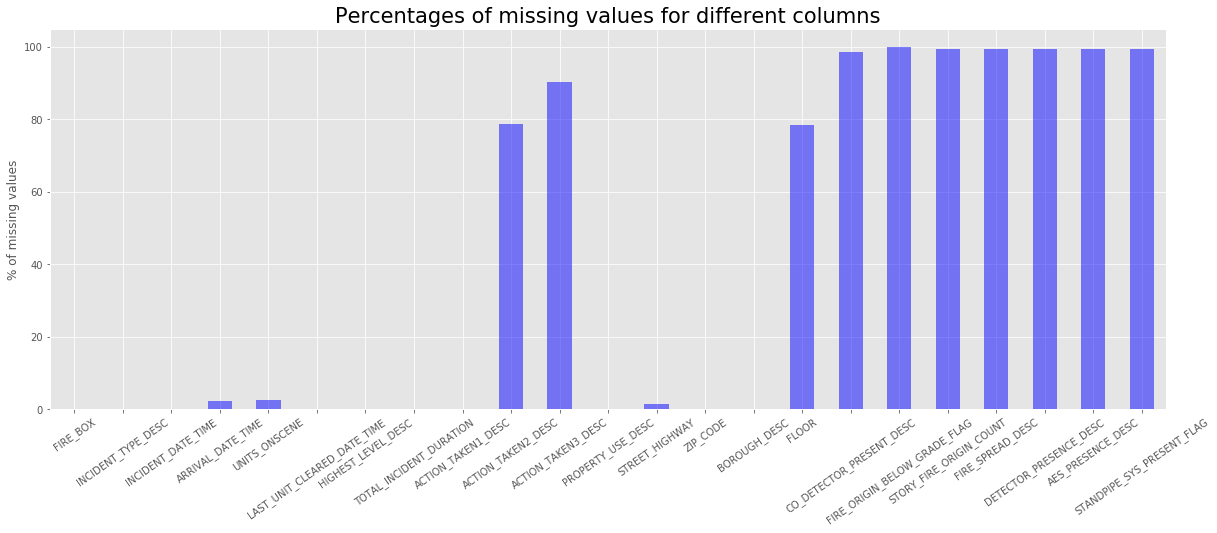

In [155]:
fig, axes = plt.subplots(figsize=(20,7))
plt.title('Percentages of missing values for different columns', fontsize=21)
plt.ylabel('% of missing values')
_ = (df.isna().mean()*100).plot.bar(rot=35, ax=axes, color='blue', alpha=0.5)

# Data Validation


In [156]:
!pip install -q tensorflow_data_validation
import tensorflow as tf
import tensorflow_data_validation as tfdv
tf.logging.set_verbosity(tf.logging.ERROR)
print('TFDV version: {}'.format(tfdv.version.__version__))

     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 3.0MB 36.7MB/s 
     |████████████████████████████████| 5.4MB 25.1MB/s 
     |████████████████████████████████| 225kB 39.9MB/s 
     |████████████████████████████████| 61kB 16.3MB/s 
     |████████████████████████████████| 235kB 38.0MB/s 
     |████████████████████████████████| 1.2MB 27.5MB/s 
     |████████████████████████████████| 153kB 41.7MB/s 
     |████████████████████████████████| 81kB 21.7MB/s 
     |████████████████████████████████| 51kB 17.9MB/s 
     |████████████████████████████████| 122kB 41.3MB/s 
     |████████████████████████████████| 235kB 41.3MB/s 
     |████████████████████████████████| 174kB 41.1MB/s 
     |████████████████████████████████| 92kB 23.1MB/s 
     |████████████████████████████████| 112kB 42.0MB/s 
ERROR: pydrive 1.3.1 has requirement oauth2client>=4.0.0, but you'll have oauth2client 3.0.0 which is incompatible.
ERROR: multiprocess 0.70.9 has requirement dill>=

In [157]:
# compute statistics for a CSV file
time_now = time()
train_stats = tfdv.generate_statistics_from_csv(f'{working_folder}Incidents_Responded_to_by_Fire_Companies.csv')
tfdv.visualize_statistics(train_stats)

# Infer schema based on statistics
schema = tfdv.infer_schema(train_stats)
# Display schema inline in table format
tfdv.display_schema(schema)

print(f"Data validation using TFDV takes {(time()- time_now)//60} minutes")

,Type,Presence,Valency,Domain
Feature name,,,,
'FIRE_BOX',BYTES,optional,single,"(-inf,inf)"
'DETECTOR_PRESENCE_DESC',STRING,optional,single,'DETECTOR_PRESENCE_DESC'
'ACTION_TAKEN2_DESC',STRING,optional,single,'ACTION_TAKEN2_DESC'
'INCIDENT_TYPE_DESC',BYTES,required,,-
'PROPERTY_USE_DESC',BYTES,optional,single,-
'ZIP_CODE',BYTES,optional,single,-
'AES_PRESENCE_DESC',STRING,optional,single,'AES_PRESENCE_DESC'
'HIGHEST_LEVEL_DESC',STRING,optional,single,'HIGHEST_LEVEL_DESC'
'STREET_HIGHWAY',BYTES,optional,single,-


,Values
Domain,
'DETECTOR_PRESENCE_DESC',"'1 - Present', 'N - None present'"
'ACTION_TAKEN2_DESC',"'00 - Action taken, other', '10 - Fire control or extinguishment, other', '11 - Extinguishment by fire service personnel', '111 - Hooked up to hydrant', '112 - Stretch 1 3/4 line, extinguish fire', '112 - Stretch 1 3/4"" line, extinguish fire', '113 - Stretch 2 1/2 line, extinguish fire', '113 - Stretch 2 1/2"" line, extinguish fire', '114 - Assisted engine company with stretching handline', '115 - Stretched precautionary line stood fast', '116 - Supplied 3 1/2 line to tower ladder', '116 - Supplied 3 1/2"" line to tower ladder', '117 - Stretch Supply line to engine company', '118 - Supplied Standpipe System', '119 - Supplied Sprinkler System', '12 - Salvage & overhaul', '14 - Contain fire (wildland)', '15 - Confine fire (wildland)', '16 - Control fire (wildland)', '17 - Manage prescribed fire (wildland)', '20 - Search & rescue, other', '201 - Operated/Assigned as Fast Unit', '21 - Search', '211 - Performed primary search, fire area', '212 - Performed secondary search, fire area', '213 - Performed primary search', '214 - Performed secondary search', '215 - Check for extension', '216 - Checked exposures', '217 - Checked surrounding properties', '22 - Rescue, remove from harm', '23 - Extricate, disentangle', '24 - Recover body', '30 - Emergency medical services, other', '301 - Operated /Assigned C.F.R.-D Engine', '302 - Provide Patient Care', '303 - Carry Down/assist EMS', '31 - Provide first aid & check for injuries', '32 - Provide basic life support (BLS)', '33 - Provide advanced life support (ALS)', '34 - Transport person', '40 - Hazardous condition, other', '41 - Identify, analyze hazardous materials', '42 - HazMat detection, monitoring, sampling, & analysis', '43 - Hazardous materials spill control and confinement', '44 - Hazardous materials leak control & containment', '45 - Remove hazard', '46 - Decontaminate persons or equipment', '47 - Decontaminate occupancy or area', '48 - Remove hazardous materials', '50 - Fires, rescues & hazardous conditions, other', '501 - Operated as Watchline Company', '51 - Ventilate', '52 - Forcible entry', '53 - Evacuate area', '54 - Determine if materials are non-hazardous', '55 - Establish safe area', '56 - Provide air supply', '57 - Provide light or electrical power', '58 - Operate apparatus or vehicle', '60 - Systems and services, other', '61 - Restore municipal services', '62 - Restore sprinkler or fire protection system', '63 - Restore fire alarm system', '64 - Shut down system', '65 - Secure property', '651 - Salvage Operations', '66 - Remove water', '70 - Assistance, other', '71 - Assist physically disabled', '72 - Assist animal', '73 - Provide manpower', '74 - Provide apparatus', '75 - Provide equipment', '76 - Provide water', '77 - Control crowd', '78 - Control traffic', '79 - Assess severe weather or natural disaster damage', '80 - Information, investigation & enforcement, other', '81 - Incident command', '811 - Assigned All Hands Chief', '812 - Assigned sector commander', '82 - Notify other agencies.', '83 - Provide information to public or media', '84 - Refer to proper authority', '85 - Enforce codes', '86 - Investigate', '87 - Investigate fire out on arrival', '91 - Fill-in or moveup'"
'AES_PRESENCE_DESC',"'1 - Present', 'N - None Present'"
'HIGHEST_LEVEL_DESC',"'0 - Initial alarm', '1 - More than initial alarm, less than Signal 7-5', '11 - First Alarm', '2 - 2nd alarm', '22 - Second Alarm', '3 - 3rd alarm', '33 - Third Alarm', '4 - 4th alarm', '44 - Fourth Alarm', '5 - 5th alarm', '55 - Fifth Alarm', '7 - Signal 7-5', '75 - All Hands Working'"
'ACTION_TAKEN1_DESC',"'00 - Action taken, other', '10 - Fire control or extinguishment, other', '11 - Extinguishment by fire service personnel', '111 - Hooked up to hydrant', '112 - Stretch 1 3/4 line, extinguish fire', '112 - Stretch 1 3/4"" line, extinguish fire', '113 - Stretch 2 1/2 line, extinguish fire', '113 - Stretch 2 1/2"" line, ex

## Distributuon of Incidents per ZIP code

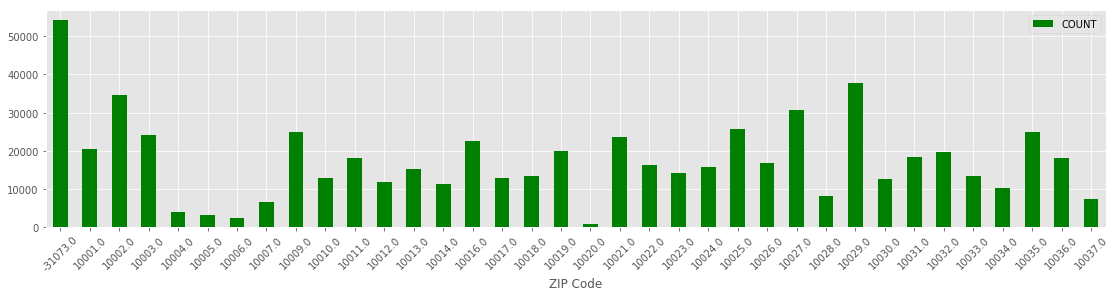

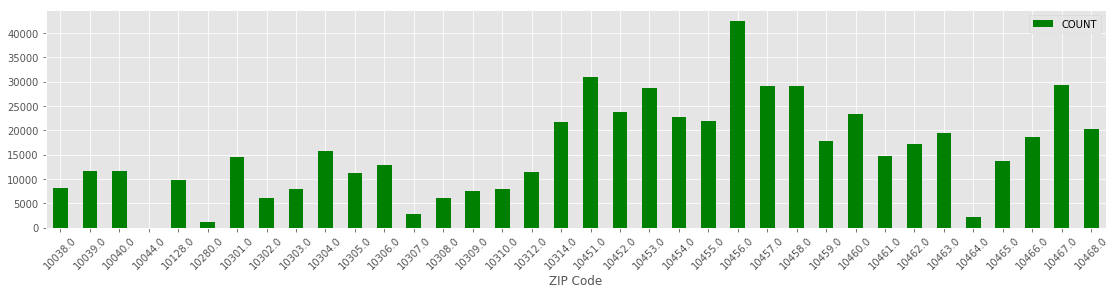

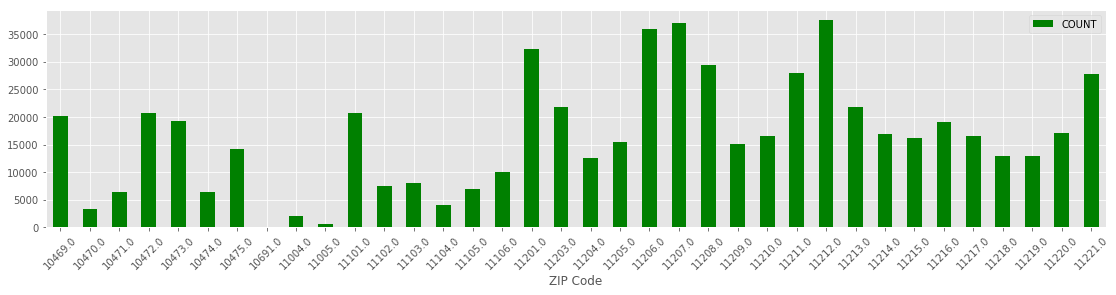

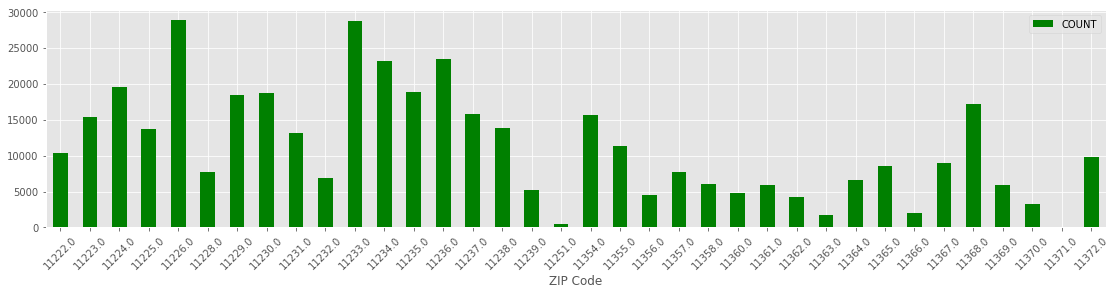

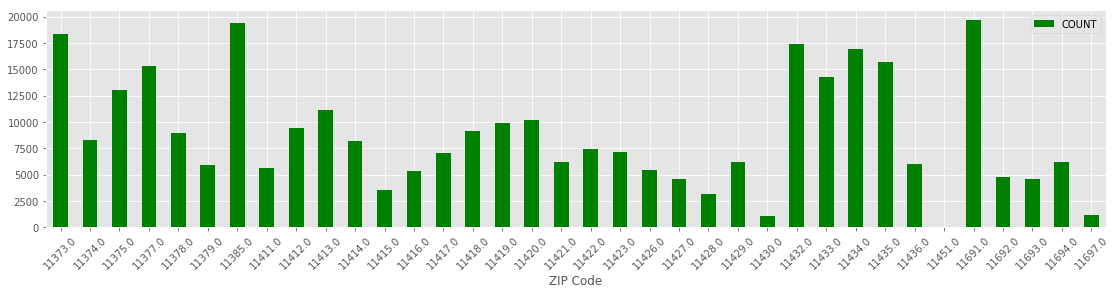

In [158]:
zip_count = pd.DataFrame(df.groupby('ZIP_CODE').FIRE_BOX.count()) # TO DO: Downcast zip codes to integer
zip_count.rename(columns={'FIRE_BOX': 'COUNT'}, inplace=True)
zip_count.reset_index(inplace=True)


n = zip_count.shape[0] // 5
list_zip_count = [zip_count[i:i+n] for i in range(0,zip_count.shape[0],n)]


for i in range(5):
    fig, ax1 = plt.subplots(figsize=(19,4))
    list_zip_count[i].set_index('ZIP_CODE').plot.bar(rot=45, ax=ax1, color='green')
    plt.xlabel('ZIP Code')

In [0]:
tmp = df.groupby('ZIP_CODE').count()
made_new_df = pd.DataFrame(tmp['FIRE_BOX'])
made_new_df.columns = ['Total_incident_number']
made_new_df.head()
del tmp

In [0]:
tmp = df.groupby('ZIP_CODE')['INCIDENT_TYPE_DESC'].value_counts()
made_new_df_multi = pd.DataFrame(tmp)
made_new_df_multi.index.names
del tmp

In [171]:
made_new_df_multi[1:20]

INCIDENT_TYPE_DESC
ZIP_CODE INCIDENT_TYPE_DESC                                                              
-31073.0 651 - Smoke scare, odor of smoke                              5644              
         322 - Motor vehicle accident with injuries                    4650              
         353 - Removal of victim(s) from stalled elevator              2898              
         710 - Malicious, mischievous false call, other                2896              
         323 - Motor vehicle/pedestrian accident (MV Ped)              2771              
         118 - Trash or rubbish fire, contained                        1813              
         555 - Defective elevator, no occupants                        1488              
         735A - Unwarranted alarm/defective condition of alarm system  1404              
         600 - Good intent call, other                                 1399              
         611 - Dispatched & canceled en route                          1103              
         622 - No incident found on arrival at dispatch address        1044              
         151 - Outside rubbish, trash or waste fire                    976               
         522 - Water or steam leak                                     883               
         311 - Medical assist, assist EMS crew                         745               
         500 - Service Call, other                                     671               
         412 - Gas leak (natural gas or LPG)                           658               
         445 - Arcing, shorted electrical equipment                    608               
         113 - Cooking fire, confined to container                     546               
         100 - Fire, other                                             484

In [0]:
listaa= []
for zip_code, new_sub_df in made_new_df_multi.groupby(level=0):
    a = [''.join(col[0][1]).strip() for col in new_sub_df['INCIDENT_TYPE_DESC'][:4].iteritems()]
    listaa.append([zip_code, a])

df_top_4_discription = pd.DataFrame(listaa, columns=['ZIP_CODE', 'Discription_top_4'])  #TODO:dtype={'ZIP_CODE': 'Int64', 'Discription_top_4': 'np.object_'}
df_top_4_discription.set_index('ZIP_CODE', inplace=True)
# df_top_4_discription.index = df_top_4_discription.index.astype('Int64')

In [173]:
df_top_4_discription.head()

,Discription_top_4
ZIP_CODE,
-31073.0,"[300 - Rescue, EMS incident, other, 651 - Smoke scare, odor of smoke, 322 - Motor vehicle accident with injuries, 353 - Removal of victim(s) from stalled elevator]"
10001.0,"[300 - Rescue, EMS incident, other, 735A - Unwarranted alarm/defective condition of alarm system, 353 - Removal of victim(s) from stalled elevator, 651 - Smoke scare, odor of smoke]"
10002.0,"[300 - Rescue, EMS incident, other, 353 - Removal of victim(s) from stalled elevator, 651 - Smoke scare, odor of smoke, 412 - Gas leak (natural gas or LPG)]"
10003.0,"[300 - Rescue, EMS incident, other, 735A - Unwarranted alarm/defective condition of alarm system, 651 - Smoke scare, odor of smoke, 710 - Malicious, mischievous false call, other]"
10004.0,"[300 - Rescue, EMS incident, other, 735A - Unwarranted alarm/defective condition of alarm system, 353 - Removal of victim(s) from stalled elevator, 740A - Unnecessary alarm/construction activities]"


In [174]:
# df_zip.index = df_zip.index.astype('Int64')
# made_new_df.index = made_new_df.index.astype('Int64')
new_df = made_new_df.merge(df_zip, how='left', left_on=made_new_df.index, 
         right_on=df_zip.index)

new_df.drop(columns=['key_0'], inplace=True)
new_df.dropna()
new_df.head()

,Total_incident_number,LAT,LNG
0,54238,NaN,NaN
1,20468,40.750633,-73.997177
2,34491,40.715775,-73.986212
3,24168,40.731829,-73.989181
4,4104,40.688630,-74.018244


In [175]:
final_df = new_df.merge(df_top_4_discription, how='left', on=new_df.index, left_index=True)
final_df.drop(columns=['key_0'], inplace=True)
final_df.dropna(inplace=True)
final_df.head()

,Total_incident_number,LAT,LNG,Discription_top_4
ZIP_CODE,,,,
10001.0,20468,40.750633,-73.997177,"[300 - Rescue, EMS incident, other, 735A - Unwarranted alarm/defective condition of alarm system, 353 - Removal of victim(s) from stalled elevator, 651 - Smoke scare, odor of smoke]"
10002.0,34491,40.715775,-73.986212,"[300 - Rescue, EMS incident, other, 353 - Removal of victim(s) from stalled elevator, 651 - Smoke scare, odor of smoke, 412 - Gas leak (natural gas or LPG)]"
10003.0,24168,40.731829,-73.989181,"[300 - Rescue, EMS incident, other, 735A - Unwarranted alarm/defective condition of alarm system, 651 - Smoke scare, odor of smoke, 710 - Malicious, mischievous false call, other]"
10004.0,4104,40.688630,-74.018244,"[300 - Rescue, EMS incident, other, 735A - Unwarranted alarm/defective condition of alarm system, 353 - Removal of victim(s) from stalled elevator, 740A - Unnecessary alarm/construction activities]"
10005.0,3108,40.706027,-74.008835,"[300 - Rescue, EMS incident, other, 735A - Unwarranted alarm/defective condition of alarm system, 353 - Removal of victim(s) from stalled elevator, 740A - Unnecessary alarm/construction activities]"


In [176]:
import folium
 
NYC_COORDINATE = (40.71, -73.90)
 
# for speed purposes
MAX_RECORDS = 260
  
map_1 = folium.Map(location=NYC_COORDINATE, zoom_start=11)
 
# add a marker for every record in the filtered data, use a clustered view
for each in final_df[0:MAX_RECORDS].iterrows():
    folium.CircleMarker(
        popup= '<br>'.join(line for line in each[1]['Discription_top_4']),
        radius=each[1]['Total_incident_number']/1500, # scale total_number of incidents by 1500
        location = [each[1]['LAT'],each[1]['LNG']],
        color='red',
        fill=True, 
        fill_color='red',
        fill_opacity=0.7
        ).add_to(map_1)
  
display(map_1)
map_1.save('map_1.html')

#[Click here to see the interactive map](http://mdavari.com/Data-Science-Portfolio/DS1_Interactive_Map/Incidents_Responded_to_by_Fire_Companies_Interactive_Map.html)

# Data Analysis

In [0]:
import calendar

fmt ='%m/%d/%Y %I:%M:%S %p'
df.INCIDENT_DATE_TIME = pd.to_datetime(df.INCIDENT_DATE_TIME, format=fmt)
df.ARRIVAL_DATE_TIME = pd.to_datetime(df.ARRIVAL_DATE_TIME, format=fmt)

In [178]:
df['RESPONCE_TIME'] = (df.ARRIVAL_DATE_TIME - df.INCIDENT_DATE_TIME) / np.timedelta64(1, 'm')
df.RESPONCE_TIME.describe()

count    2.456446e+06
mean     5.134895e+00
std      1.166291e+01
min     -1.047000e+02
25%      3.650000e+00
50%      4.583333e+00
75%      5.783333e+00
max      1.000497e+04
Name: RESPONCE_TIME, dtype: float64

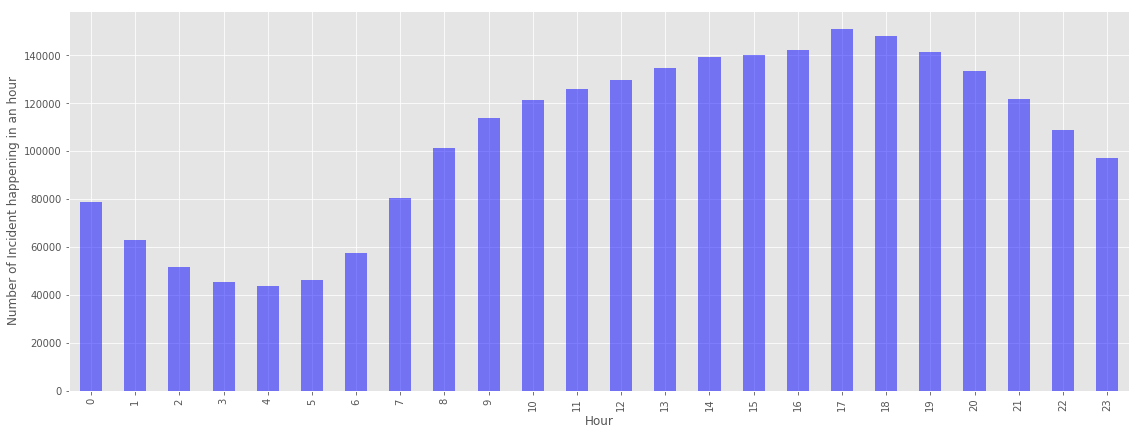

In [179]:
df['hour'] = df.INCIDENT_DATE_TIME.dt.hour
df['day'] = df.INCIDENT_DATE_TIME.dt.day 
df['day_of_week'] = df.INCIDENT_DATE_TIME.dt.dayofweek 
df['month'] = df.INCIDENT_DATE_TIME.dt.month 
df['year'] = df.INCIDENT_DATE_TIME.dt.year

fig, ax1= plt.subplots(figsize=(19,7))
df.groupby('hour').FIRE_BOX.count().plot.bar(color='blue', alpha=0.5)
plt.xlabel('Hour')
_ = plt.ylabel('Number of Incident happening in an hour')

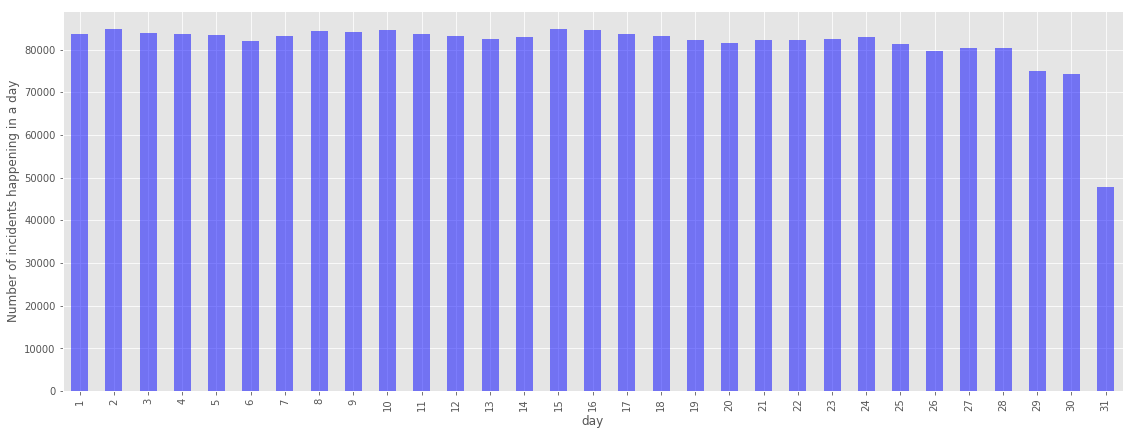

In [180]:
fig, ax1= plt.subplots(figsize=(19,7))
df.groupby('day').FIRE_BOX.count().plot.bar(color='blue', alpha=0.5)
plt.xlabel('day')
_ = plt.ylabel('Number of incidents happening in a day')

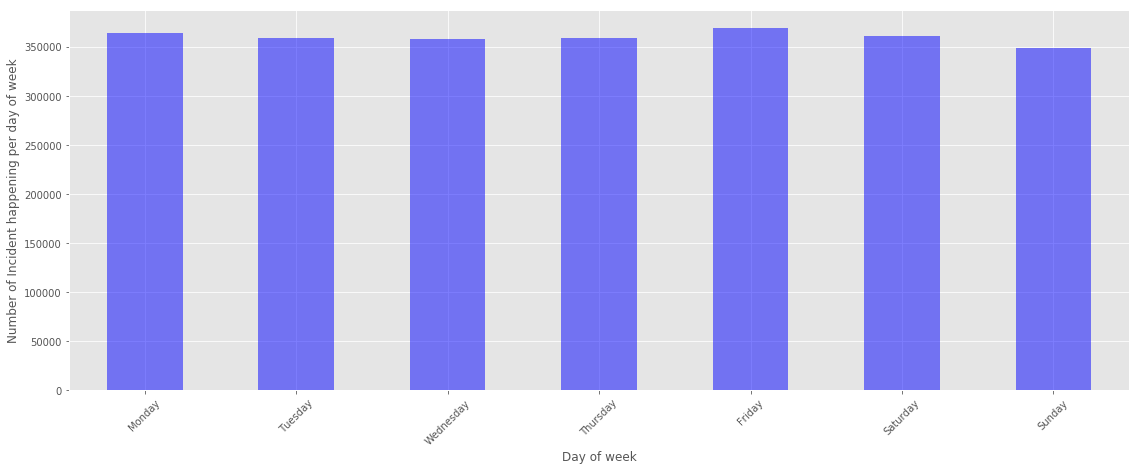

In [181]:
incidents_day_of_week = df.groupby('day_of_week').FIRE_BOX.count()
incidents_day_of_week.index=[calendar.day_name[x] for x in range(0,7)]

fig, ax1= plt.subplots(figsize=(19,7))
incidents_day_of_week.plot.bar(color='blue', alpha=0.5, rot=45)
plt.xlabel('Day of week')
_ = plt.ylabel('Number of Incident happening per day of week')

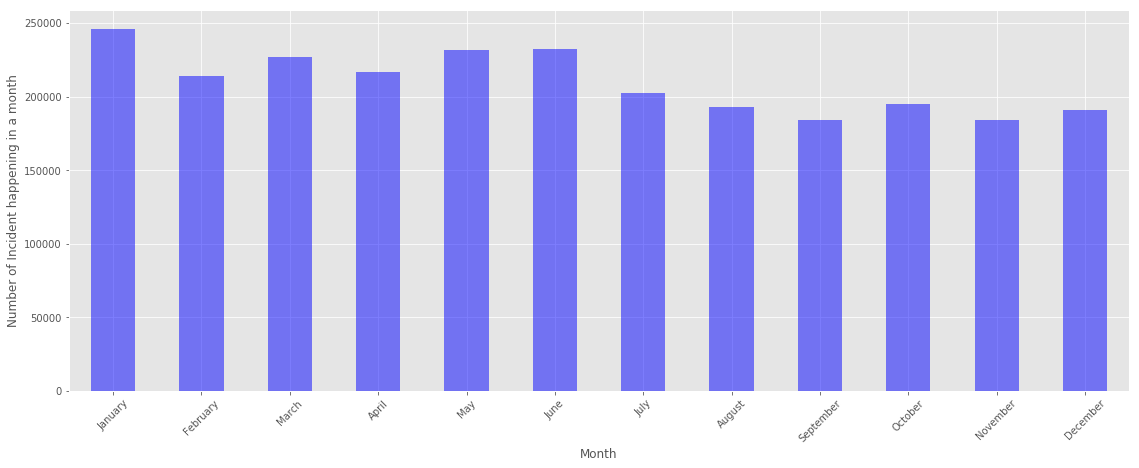

In [182]:
fig, ax1= plt.subplots(figsize=(19,7))
incidents_per_month = df.groupby('month').FIRE_BOX.count()
incidents_per_month.index = [calendar.month_name[i] for i in range(1,13)]
incidents_per_month.plot.bar(color='blue', alpha=0.5, rot=45)
plt.xlabel('Month')
_ = plt.ylabel('Number of Incident happening in a month')

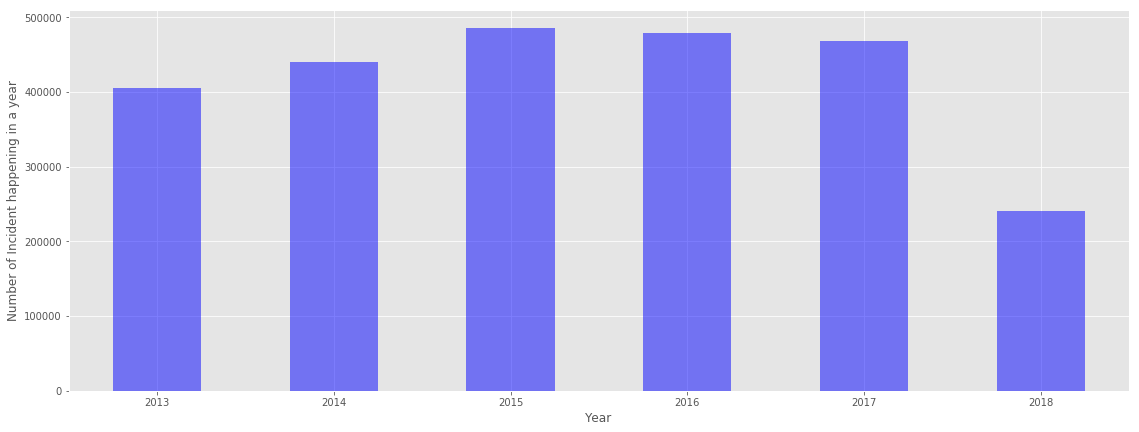

In [183]:
fig, ax1= plt.subplots(figsize=(19,7))
df.groupby('year').FIRE_BOX.count().plot.bar(rot=0, color='blue', alpha=0.5)
plt.xlabel('Year')
_ = plt.ylabel('Number of Incident happening in a year')

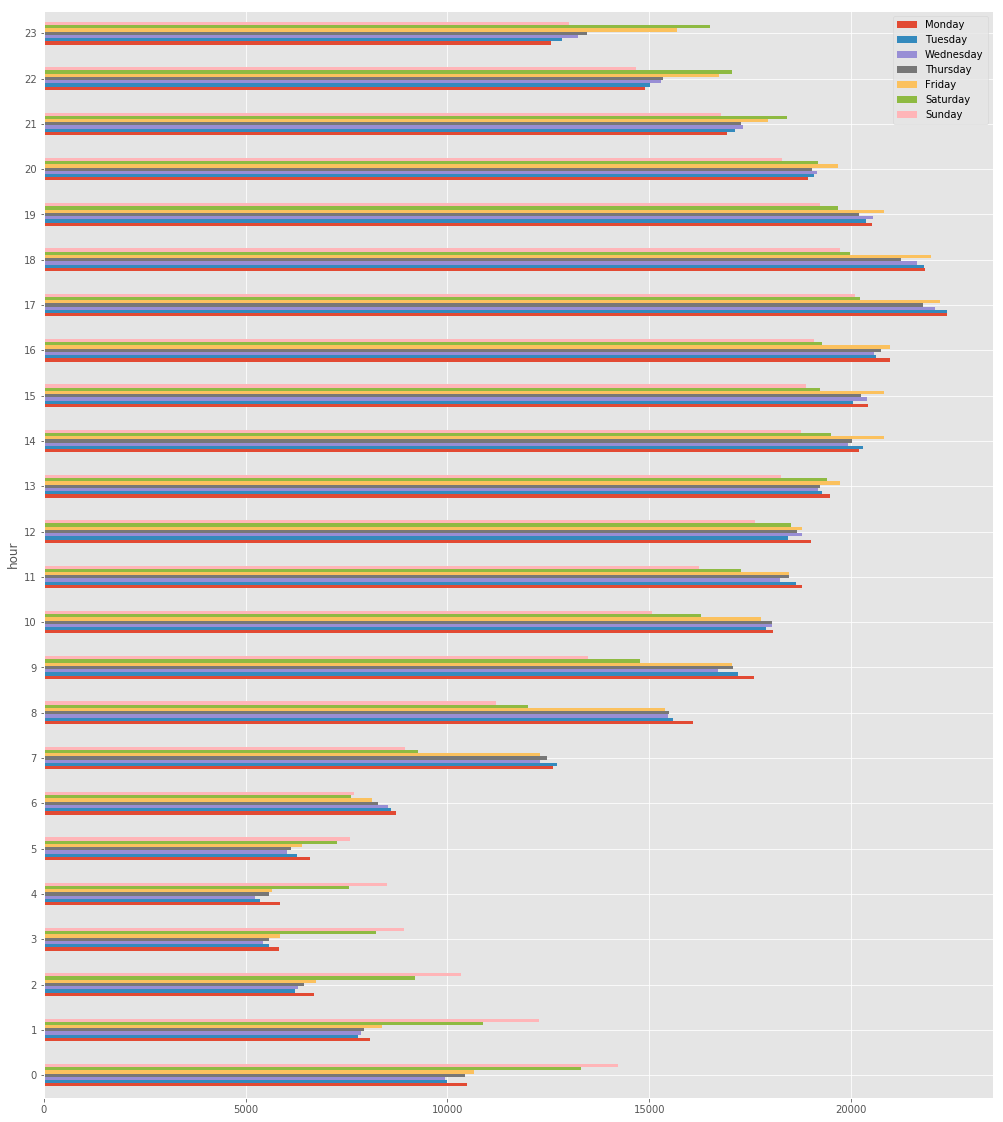

In [184]:
day_of_week_hour = df.groupby(['hour', 'day_of_week']).count().INCIDENT_DATE_TIME
day_of_week_hour.unstack().plot.barh(figsize=(17,20))
_ = plt.legend(labels=[calendar.day_name[i] for i in range(0,7)])

In [185]:
df.sample(5)

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,ACTION_TAKEN2_DESC,ACTION_TAKEN3_DESC,PROPERTY_USE_DESC,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,FLOOR,CO_DETECTOR_PRESENT_DESC,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG,RESPONCE_TIME,hour,day,day_of_week,month,year
IM_INCIDENT_KEY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56342203,3063,"300 - Rescue, EMS incident, other",2013-08-23 08:10:12,2013-08-23 08:14:49,2.0,08/23/2013 08:29:17 AM,"1 - More than initial alarm, less than Signal 7-5",1145.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,HARROD AVE,10472.0,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.616667,8,23,4,8,2013
56664332,2270,322 - Motor vehicle accident with injuries,2013-12-16 09:23:47,2013-12-16 09:28:30,2.0,12/16/2013 09:35:43 AM,"1 - More than initial alarm, less than Signal 7-5",716.0,73 - Provide manpower,74 - Provide apparatus,75 - Provide equipment,"962 - Residential street, road or residential driveway",E 86 ST,11236.0,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.716667,9,16,0,12,2013
57551840,632,"113 - Cooking fire, confined to container",2014-09-16 21:19:20,2014-09-16 21:24:25,2.0,09/16/2014 09:31:41 PM,"1 - More than initial alarm, less than Signal 7-5",741.0,11 - Extinguishment by fire service personnel,51 - Ventilate,NaN,429 - Multifamily dwelling,W 25 ST,10010.0,1 - Manhattan,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.083333,21,16,1,9,2014
57731653,9556,"300 - Rescue, EMS incident, other",2014-11-10 17:25:05,2014-11-10 17:30:50,1.0,11/10/2014 05:48:55 PM,"1 - More than initial alarm, less than Signal 7-5",1430.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,70 AVE,11375.0,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.750000,17,10,0,11,2014
59367532,7143,"300 - Rescue, EMS incident, other",2016-01-11 13:30:24,2016-01-11 13:36:22,1.0,01/11/2016 01:53:10 PM,"1 - More than initial alarm, less than Signal 7-5",1366.0,"00 - Action taken, other",NaN,NaN,UUU - Undetermined,44 RD,11101.0,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.966667,13,11,0,1,2016


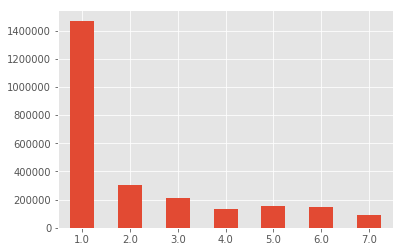

In [186]:
df.UNITS_ONSCENE.apply(lambda x: x if x < 7 else 7).value_counts().sort_index().plot.bar(rot=0) # TO DO: '7' is 7 and above!

In [187]:
df.TOTAL_INCIDENT_DURATION = df.TOTAL_INCIDENT_DURATION.apply(lambda x:x//60)
low, high = df.TOTAL_INCIDENT_DURATION.quantile(q=[0.01, 0.99])
df.TOTAL_INCIDENT_DURATION = df.TOTAL_INCIDENT_DURATION.apply(lambda x: x if (x < high) else high )
df.TOTAL_INCIDENT_DURATION = df.TOTAL_INCIDENT_DURATION.apply(lambda x: x if (x > low) else low )


df.TOTAL_INCIDENT_DURATION.describe()

count    2.518758e+06
mean     2.186225e+01
std      1.717521e+01
min      2.000000e+00
25%      1.200000e+01
50%      1.700000e+01
75%      2.500000e+01
max      1.030000e+02
Name: TOTAL_INCIDENT_DURATION, dtype: float64

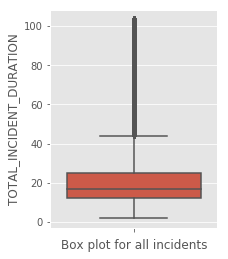

In [188]:
plt.figure(figsize=(3,4))
_ = sns.boxplot(y='TOTAL_INCIDENT_DURATION', data=df)
_ = plt.xlabel('Box plot for all incidents')

In [0]:
low, high = df.UNITS_ONSCENE.quantile(q=[0, .99])
df.UNITS_ONSCENE = df.UNITS_ONSCENE.apply(lambda x: x if x <= high else 8)

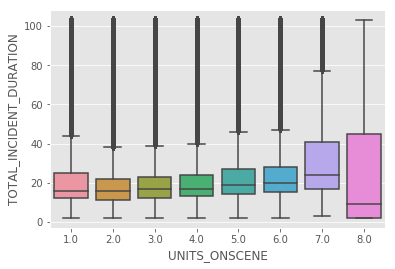

In [190]:
_ = sns.boxplot(x='UNITS_ONSCENE', y='TOTAL_INCIDENT_DURATION', data=df)

In [0]:
df[['INCIDENT_TYPE_DESC']] = df[['INCIDENT_TYPE_DESC']].apply(lambda x: x.mask(x.map(x.value_counts()/x.shape[0]) < 0.01, 'other'))

In [192]:
df.INCIDENT_TYPE_DESC.value_counts()

300 - Rescue, EMS incident, other                               906466
other                                                           363314
651 - Smoke scare, odor of smoke                                161886
353 - Removal of victim(s) from stalled elevator                131509
710 - Malicious, mischievous false call, other                  129466
522 - Water or steam leak                                       122716
412 - Gas leak (natural gas or LPG)                             119324
735A - Unwarranted alarm/defective condition of alarm system    112158
113 - Cooking fire, confined to container                       96142 
555 - Defective elevator, no occupants                          54051 
736 - CO detector activation due to malfunction                 50483 
322 - Motor vehicle accident with injuries                      49389 
445 - Arcing, shorted electrical equipment                      41767 
740A - Unnecessary alarm/construction activities                34300 
5001 -

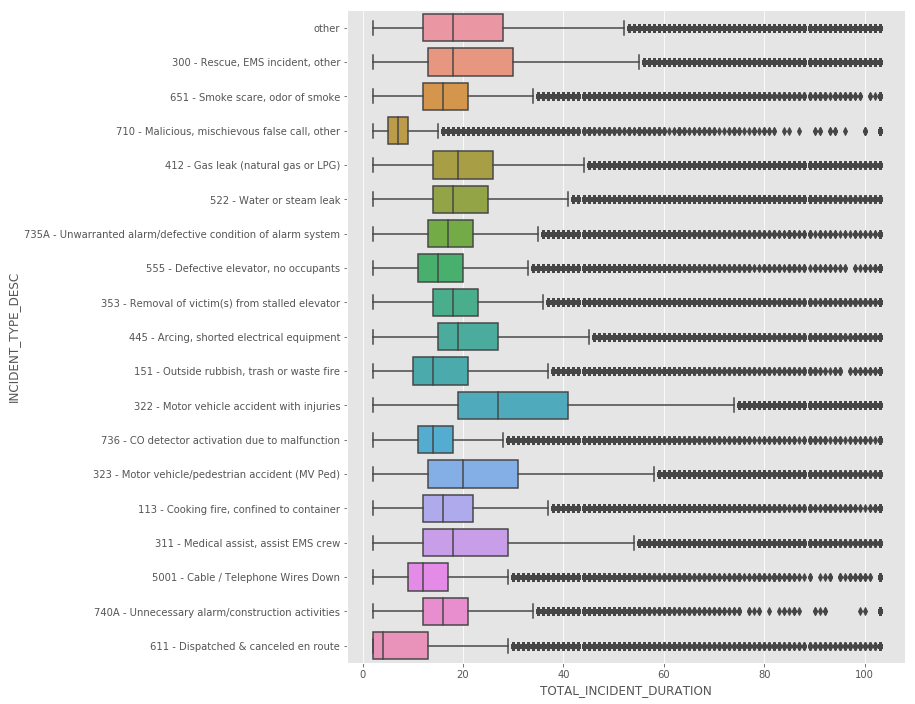

In [193]:
plt.figure(figsize=(10,12))
ax = sns.boxplot(y='INCIDENT_TYPE_DESC' , x='TOTAL_INCIDENT_DURATION', data=df )
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

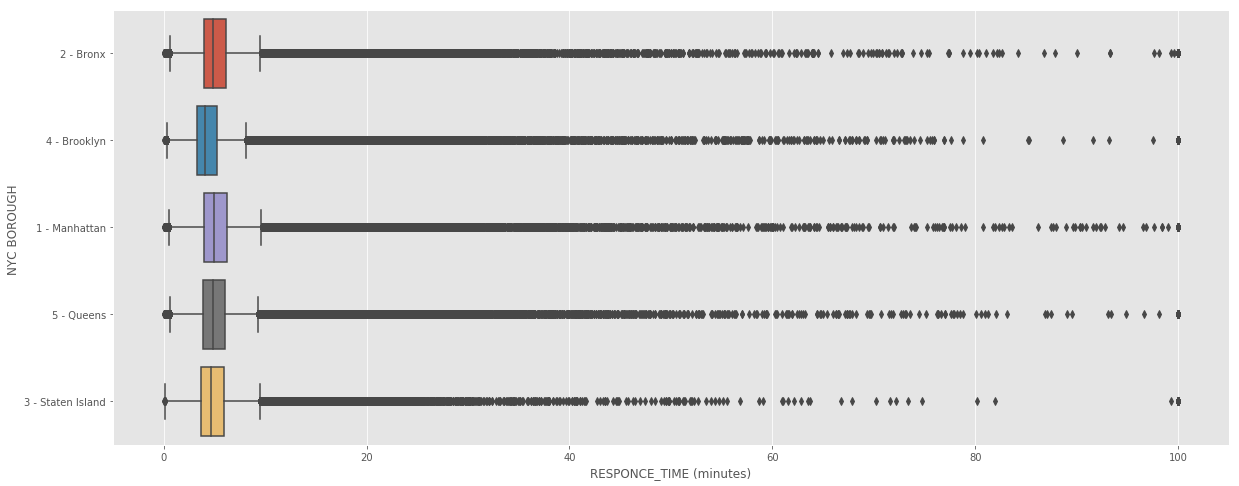

In [194]:
df.RESPONCE_TIME = df.RESPONCE_TIME.apply(lambda x: x if x < 100 else 100)
df.RESPONCE_TIME = df.RESPONCE_TIME.apply(lambda x: x if x > 0 else 0)

plt.figure(figsize=(20,8))
sns.boxplot(x='RESPONCE_TIME', y='BOROUGH_DESC', data=df, whis=1.5)
_ = plt.xlabel('RESPONCE_TIME (minutes)')
_ = plt.ylabel('NYC BOROUGH ')

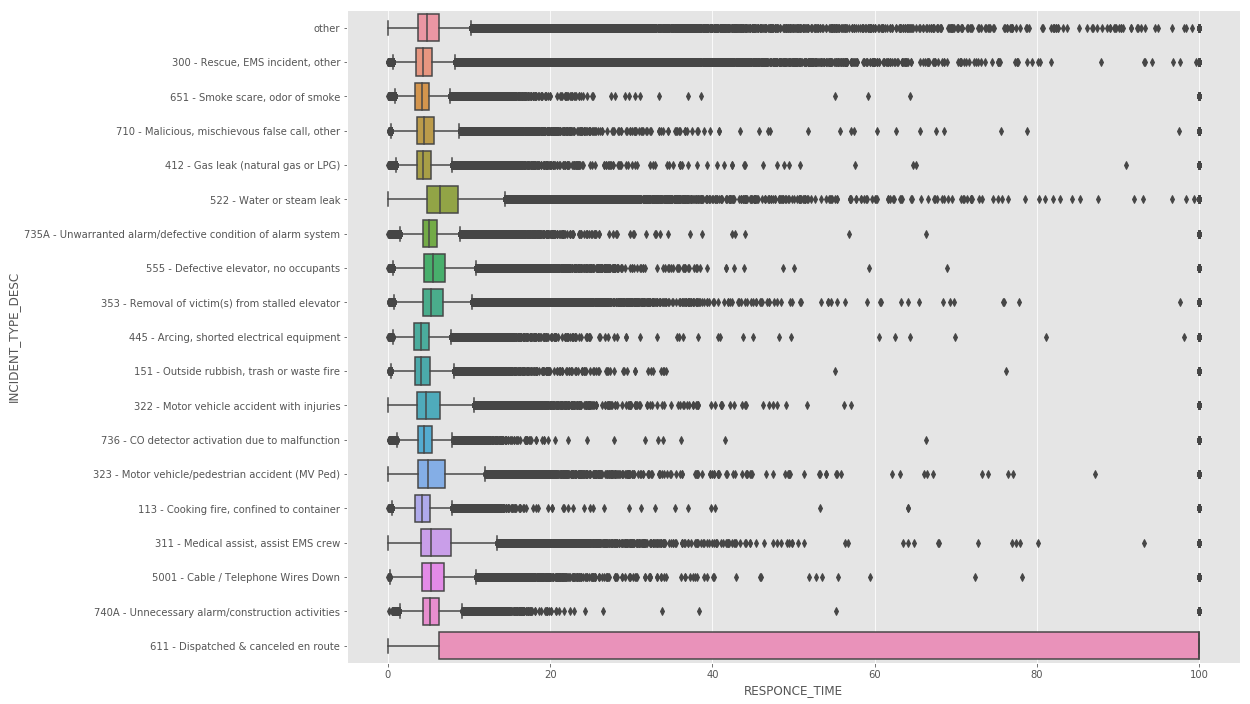

In [195]:
_ = plt.figure(figsize=(16,12))
ax = sns.boxplot(y='INCIDENT_TYPE_DESC' , x='RESPONCE_TIME', data=df )